In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score


In [2]:
def compare_models(models, param_grids, X_train, y_train, X_val, y_val, scoring_metric='accuracy'):
    best_models = []
    
    for model, param_grid in zip(models, param_grids):
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2, scoring=scoring_metric)
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        
        # Store the best model and its parameters
        best_models.append({'model': best_model, 'params': best_params})
    
    # Evaluate the best models on a separate validation set
    best_model_scores = []
    for model_info in best_models:
        best_model = model_info['model']
        y_pred = best_model.predict(X_val)
        
        if scoring_metric == 'accuracy':
            score = accuracy_score(y_val, y_pred)
        elif scoring_metric == 'f1':
            score = f1_score(y_val, y_pred)
        else:
            # Add more evaluation metrics as needed
            pass
        
        best_model_scores.append({'model': best_model, 'score': score})
    
    # Find and return the model with the highest score
    best_model_scores.sort(key=lambda x: x['score'], reverse=True)
    best_model = best_model_scores[0]['model']
    best_score = best_model_scores[0]['score']
    
    return best_model, best_score

In [3]:
ROOT_PATH = Path(Path(os.getcwd())/"../output/features")

In [4]:
experiment              = 1

train_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_train_features.csv',  header = None)
val_nevus_df = pd.read_csv(ROOT_PATH/f'{experiment}_nevus_val_features.csv',  header = None)

train_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_train_features.csv',  header = None)
val_others_df = pd.read_csv(ROOT_PATH/f'{experiment}_others_val_features.csv',  header = None)

In [7]:
train_nevus_df.head()


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.003906,0.013918,4.469401,0.053498,4.851804,19.539026,0.003906,0.009034,2.631374,0.024797,...,0.082142,0.998444,0.997566,0.998025,0.997596,0.008026,0.006675,0.007262,0.006747,0.0
1,0.003906,0.016861,5.507503,0.076684,4.248592,31.170776,0.003906,0.012557,3.814509,0.044274,...,0.074121,0.951735,0.935772,0.966793,0.941116,0.005917,0.005163,0.006939,0.005494,0.0
2,0.003906,0.010394,2.990068,0.031561,5.328352,7.777392,0.003906,0.008979,2.738987,0.024545,...,0.056280,0.966268,0.961585,0.987211,0.960745,0.003513,0.003063,0.004049,0.003167,0.0
3,0.003906,0.012363,4.082595,0.043033,5.251833,16.058785,0.003906,0.012142,4.124982,0.041650,...,0.075989,0.994432,0.992293,0.996052,0.991632,0.006968,0.006001,0.007095,0.005774,0.0
4,0.003906,0.006913,2.142126,0.016140,6.226823,4.379654,0.003906,0.004907,1.150292,0.010072,...,0.025058,0.989266,0.985394,0.990049,0.983869,0.000751,0.000659,0.000779,0.000628,0.0


In [8]:
train_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.003906,0.009606,2.806666,0.027530,5.431317,7.951028,0.003906,0.006136,2.785363,0.013546,...,0.053044,0.997793,0.996085,0.996668,0.996015,0.003534,0.002844,0.002947,0.002814,1.0
1,0.003906,0.006448,2.787260,0.014551,6.778739,7.278751,0.003906,0.005142,2.721357,0.010675,...,0.050316,0.999276,0.998571,0.998930,0.998368,0.003292,0.002568,0.002835,0.002532,1.0
2,0.003906,0.006103,4.220309,0.013441,6.879826,27.884227,0.003906,0.005633,4.826642,0.012031,...,0.063799,0.999452,0.999025,0.999265,0.999043,0.004485,0.004066,0.004174,0.004070,1.0
3,0.003906,0.003167,1.077037,0.006475,7.521644,0.726574,0.003906,0.003379,0.986661,0.006830,...,0.029196,0.998814,0.997704,0.997976,0.997284,0.001158,0.000867,0.000930,0.000852,1.0
4,0.003906,0.004635,0.682376,0.009407,6.827863,-0.922162,0.003906,0.006414,1.481143,0.014437,...,0.037842,0.993753,0.990602,0.991675,0.990910,0.001662,0.001427,0.001471,0.001432,1.0


In [9]:
val_nevus_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.003906,0.005823,2.364935,0.012588,6.779106,5.530289,0.003906,0.004991,1.482931,0.010283,...,0.038032,0.998897,0.997914,0.998739,0.998319,0.001754,0.001394,0.001612,0.001446,0.0
1,0.003906,0.009142,3.718721,0.025302,6.147185,14.006352,0.003906,0.007321,3.027892,0.017628,...,0.061823,0.999717,0.999367,0.999556,0.999338,0.005202,0.003979,0.004338,0.003822,0.0
2,0.003906,0.016930,5.847648,0.077283,4.305944,35.729718,0.003906,0.014264,4.803985,0.055994,...,0.102086,0.922029,0.898623,0.959208,0.925013,0.011456,0.009780,0.012511,0.010422,0.0
3,0.003906,0.008305,2.742986,0.021562,5.939784,6.761978,0.003906,0.006237,2.064833,0.013864,...,0.046333,0.996991,0.995799,0.996912,0.995370,0.002437,0.002136,0.002439,0.002147,0.0
4,0.003906,0.006181,1.944950,0.013685,6.563637,3.039227,0.003906,0.004799,1.584398,0.009802,...,0.033146,0.994599,0.988368,0.991820,0.990408,0.001381,0.001034,0.001313,0.001099,0.0


In [10]:
val_others_df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.003906,0.008878,3.390305,0.024082,6.211118,10.687126,0.003906,0.005850,2.542928,0.012668,...,0.050440,0.999505,0.999066,0.999317,0.998961,0.003402,0.002603,0.002810,0.002544,1.0
1,0.003906,0.010202,3.419856,0.030553,5.749721,10.939209,0.003906,0.006095,1.816727,0.013418,...,0.037710,0.994432,0.989381,0.991445,0.990024,0.001929,0.001398,0.001591,0.001422,1.0
2,0.003906,0.004433,1.338847,0.008937,7.031940,2.135412,0.003906,0.003618,0.682986,0.007257,...,0.028565,0.997239,0.994658,0.995662,0.994953,0.001064,0.000791,0.000871,0.000816,1.0
3,0.003906,0.009631,5.814924,0.027652,6.185551,47.484610,0.003906,0.006851,5.089260,0.015922,...,0.083875,0.998930,0.998067,0.998611,0.998278,0.007432,0.006944,0.007186,0.007035,1.0
4,0.003906,0.009426,3.719526,0.026650,6.079620,13.776778,0.003906,0.006489,2.533717,0.014684,...,0.052021,0.998940,0.998154,0.998744,0.998492,0.003106,0.002541,0.002865,0.002706,1.0


In [11]:
# Concatenate the 'nevus' and 'others' dataframes
train_features = pd.concat([train_nevus_df, train_others_df], ignore_index=True)
val_features = pd.concat([val_nevus_df, val_others_df], ignore_index=True)

# Shuffle the dataset
train_features = train_features.sample(frac=1, random_state=42)
val_features = val_features.sample(frac=1, random_state=42)


In [12]:
X_train = train_features.iloc[:,:-1]
y_train = train_features.iloc[:,-1]

X_val = val_features.iloc[:,:-1]
y_val = val_features.iloc[:,-1]

X_val.head()


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
256,0.003906,0.015308,4.734322,0.063897,4.533911,21.859895,0.003906,0.013329,4.272453,0.049391,...,0.106809,0.096699,0.985546,0.984856,0.990267,0.979659,0.010788,0.009500,0.011408,0.009351
352,0.003906,0.010297,3.534212,0.031049,5.566645,12.432142,0.003906,0.009356,3.141587,0.026314,...,0.056404,0.053236,0.965103,0.941492,0.957181,0.942727,0.003664,0.002667,0.003181,0.002834
298,0.003906,0.006858,2.633227,0.015945,6.536251,6.469569,0.003906,0.006092,2.589907,0.013407,...,0.063595,0.063831,0.999600,0.999391,0.999474,0.999422,0.004389,0.004053,0.004044,0.004074
581,0.003906,0.010419,3.944143,0.031697,5.429946,20.272506,0.003906,0.005326,2.026458,0.011168,...,0.054307,0.049575,0.995108,0.992882,0.994276,0.991149,0.003228,0.002434,0.002949,0.002458
1287,0.003906,0.005283,1.672374,0.011052,6.868450,2.074266,0.003906,0.003673,0.803883,0.007360,...,0.034227,0.032615,0.998948,0.998293,0.998657,0.998257,0.001315,0.001087,0.001171,0.001064


In [13]:
# Standardizing the training data (mean = 0, std = 1)
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(scaler.fit_transform(X_train))
X_val_normalized = pd.DataFrame(scaler.transform(X_val))

In [14]:
# Encoding the label column
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

In [15]:
# Define the list of models and their respective hyperparameter grids
models = [SVC(),
          #LogisticRegression(), 
        KNeighborsClassifier(),
        RandomForestClassifier()] 
        

param_grids = [{'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001, 0.0001]},
                #{'penalty' : ['l1', 'l2', 'elasticnet', None], 'C':[0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']},
                {'n_neighbors': [3, 5, 7, 9], 'weights' : ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]}, 
                {'n_estimators' : [10, 50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
]

# Call the function to compare models and get the best one
best_model, best_score = compare_models(models, param_grids, X_train_normalized, y_train_encoded, X_val_normalized, y_val_encoded, scoring_metric='accuracy')

print("Best Model:", best_model)
print("Best Score:", best_score)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.0

In [14]:
# = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'), 'C':[0.1, 1, 10, 100, 1000], 'gamma':[0.001, 0.0001]}
#svc = SVC()

# Create a GridSearchCV object with a classifier and the parameter grid
#grid_search = GridSearchCV(estimator=svc, param_grid=parameters, cv=10, verbose=10)

# Fit the grid search to your training data
#grid_search.fit(X_train_normalized, y_train_encoded)

# Get the best hyperparameters and the best model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

In [19]:
# best_params

In [16]:
y_pred = best_model.predict(X_val_normalized)
print(y_pred)

[0 1 1 ... 0 0 1]


### Model evaluation

In [17]:
fpr, tpr, _ = roc_curve(y_val_encoded, y_pred)
roc_auc = auc(fpr, tpr)

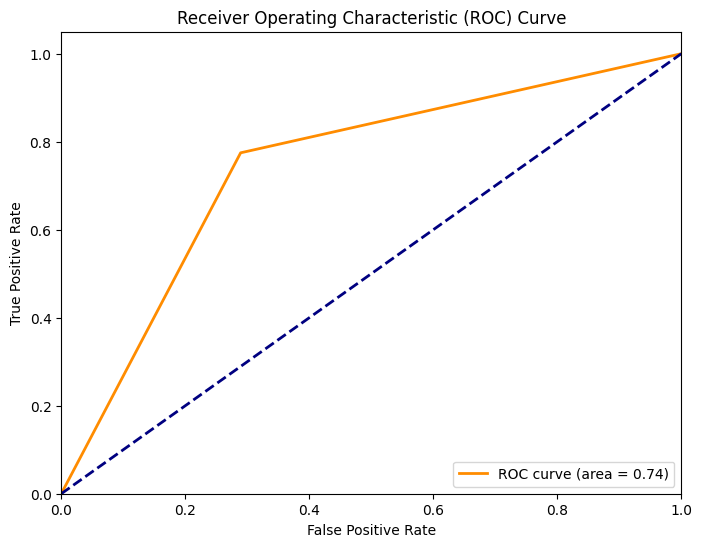

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.7427427427427428
